# **LIBRARIES**

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import asarray
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import datetime 
import pathlib

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [ ]:
seed = 42127
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **DATASET**


RGB images of 96x96 pixels.


In [ ]:
def genAugmLayer(seed): 
    return tf.keras.Sequential([
     tfkl.RandomFlip("horizontal_and_vertical"),
     tfkl.RandomRotation(0.5),
     tfkl.RandomZoom( height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3),fill_mode = 'reflect',seed=seed) ])

In [ ]:
imbalClasses = tf.keras.utils.image_dataset_from_directory( 
    '/kaggle/input/correctedbal',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    subset = 'training',
    validation_split=0.15,
    seed=seed,
)

data_augmentation1 = genAugmLayer(17) 
dataAugmImbal = imbalClasses.map(lambda x , y : (data_augmentation1(x), y)) 
data_augmentation2 = genAugmLayer(271) 
dataAugmImbal = dataAugmImbal.concatenate(imbalClasses.map(lambda x , y : (data_augmentation2(x), y))) #double samples of classes 1 and 6 

Found 414 files belonging to 8 classes.
Using 352 files for training.


***UNIVERSAL AUGMENTATION***

In [ ]:
datapath = '/kaggle/input/annhw1/training_data_final'
training_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32, 
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.15,
    subset='training'
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32, 
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.15,
    subset='validation'
)


#-------------WEIGHTS ----------------------------------
labels = np.concatenate([y for x, y in training_set], axis=0) 
class_weights = class_weight.compute_class_weight(class_weight='balanced' ,classes = [i for i in range(8)] , y = np.argmax(labels, axis=-1) ) 
weights = dict(enumerate(class_weights)) 
print(weights)
#-------------------------------------------------------

Found 3542 files belonging to 8 classes.
Using 3011 files for training.
Found 3542 files belonging to 8 classes.
Using 531 files for validation.
{0: 2.3377329192546585, 1: 0.8217794759825328, 2: 0.8940023752969121, 3: 0.8515271493212669, 4: 0.8235776805251641, 5: 1.9914021164021165, 6: 0.8111530172413793, 7: 0.8982696897374701}


***RESCALING***

In [ ]:
data_augmentation = genAugmLayer(89)
training_set = training_set.concatenate(training_set.map(lambda x , y : (data_augmentation(x), y)) ) #total augm
training_set = training_set.concatenate(dataAugmImbal)
training_set = training_set.concatenate(imbalClasses) #OVERSAMPLING classes 1 and 6 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

# **Transfer Learning**

In [ ]:
initial_time = datetime.datetime.now()
input_shape = (96, 96, 3)
epochs = 100 

In [ ]:
training_set = training_set.map(lambda x,y: (tf.keras.applications.inception_v3.preprocess_input(x), y))
validation_set = validation_set.map(lambda x,y: (tf.keras.applications.inception_v3.preprocess_input(x),y))

In [ ]:
supernet = tf.keras.applications.inception_v3.InceptionV3( include_top=False, weights='imagenet')
supernet.trainable = True

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
#ARCHITECTURE
input_layer = tfkl.Input(input_shape)
x = tfkl.Resizing(height = 299, width = 299, interpolation = 'bicubic' )(input_layer)
x = supernet(x)
x = tfkl.GlobalAveragePooling2D()(x) 
x = tfkl.Dropout(rate=0.35)(x)
x = tfkl.Dense(units=80, name='Dense3', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer = tf.keras.regularizers.L2(0.01),   activation='relu')(x)
x = tfkl.Dropout(rate=0.35)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)
    
model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics='accuracy')

In [ ]:
from datetime import datetime
def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)
    now = datetime.now().strftime('%b%d_%H-%M-%S')
    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
    callbacks = []
    
    # Model checkpoint
      # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
          
    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), save_weights_only=True, save_best_only=True) #play here 
      
    callbacks.append(ckpt_callback)
    
    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True) #tuning point
    callbacks.append(es_callback)
    return callbacks

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Dense3 (Dense)               (None, 80)                163920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0     

In [ ]:
for i, layer in enumerate(model.get_layer('inception_v3').layers[:-1]):
    layer.trainable=False

for i, layer in enumerate(model.get_layer('inception_v3').layers[:30]):
    layer.trainable=True
    
for i, layer in enumerate(model.get_layer('inception_v3').layers[-40:-1]):
    layer.trainable = True

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Dense3 (Dense)               (None, 80)                163920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='myModel_TESTING')

history = model.fit(
    x = training_set,
    epochs = epochs,
    validation_data = validation_set, 
    callbacks = callbacks
    ,class_weight = weights 
).history

Epoch 1/100
223/223 [==============================] - 138s 482ms/step - loss: 3.1535 - accuracy: 0.4481 - val_loss: 2.9142 - val_accuracy: 0.4859
Epoch 2/100
223/223 [==============================] - 108s 482ms/step - loss: 2.1573 - accuracy: 0.7535 - val_loss: 2.6679 - val_accuracy: 0.5669
Epoch 3/100
223/223 [==============================] - 108s 485ms/step - loss: 1.5772 - accuracy: 0.9003 - val_loss: 1.8554 - val_accuracy: 0.7985
Epoch 4/100
223/223 [==============================] - 108s 485ms/step - loss: 1.3065 - accuracy: 0.9486 - val_loss: 1.7147 - val_accuracy: 0.8079
Epoch 5/100
223/223 [==============================] - 108s 484ms/step - loss: 1.0977 - accuracy: 0.9716 - val_loss: 1.5282 - val_accuracy: 0.8324
Epoch 6/100
223/223 [==============================] - 108s 484ms/step - loss: 0.9631 - accuracy: 0.9771 - val_loss: 1.7363 - val_accuracy: 0.7533
Epoch 7/100
223/223 [==============================] - 108s 484ms/step - loss: 0.8536 - accuracy: 0.9730 - val_loss: 1

In [ ]:
model.save("models/rew")

17/17 [==============================] - 2s 135ms/step - loss: 0.3353 - accuracy: 0.9228
{'loss': 0.3353317081928253, 'accuracy': 0.9227871894836426}
Accuracy: 0.9228
Precision: 0.9215
Recall: 0.9195
F1: 0.9188
F1 (per class):
[0.81632653 0.92207792 0.95287958 0.89932886 0.92413793 1.
 0.95104895 0.88484848]
WORST CLASS: Species: 1


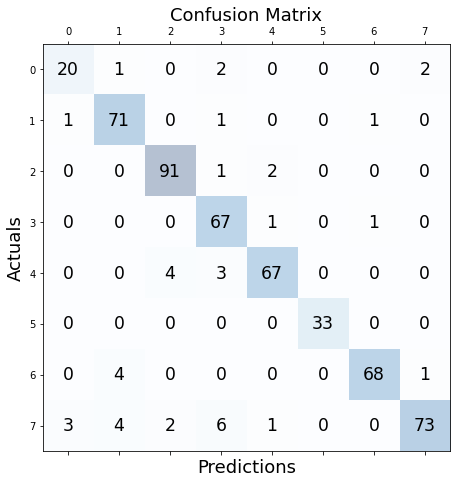

In [ ]:
metrics = model.evaluate(validation_set, return_dict=True)
print(metrics)

DATASET_EVAL = validation_set
labels = np.concatenate([y for x, y in DATASET_EVAL], axis=0) 
predictions = model.predict(validation_set) 

assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):')
print(f1_classes)

print('WORST CLASS: Species:', np.argmin(f1_classes)+1)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Before reaching 6 million parameters unlocked we manually (by hand) tried to carry out some experiments on the number of trainable layers and on the learning rate (kept very low).   

Finally, we trained the model with circa 6 millions of parameters. As you can see, validation accuracy was pretty high so we had big expectations on this notebook. And, in fact, it brought us from roughly 81% obtained with slightly less than a million parameters unlocked in the very same model (see inception_ft notebook) to 87% on the remote test set.    

Even tough our expectations were not completely met we were satisfied with this attempt as we realized that even with only roughly 25% of the weights of the architecture unlocked we were able to crack top 20 (in that specific moment of the competition). 